## Comparing K-means or GMM classifier on SAR data to optical WOfS inundation summaries for an example area

In [2]:
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

In [3]:
dc = datacube.Datacube(config='radar.conf')

In [490]:
#define the sample region and train the SAR classifier

#section of coast south of Field Island
# x=(132.33,132.39), y=(-12.25,-12.22)

#first get Field Island (index 13) from the wetlands shapefile
#open the shapefile with all the Ramsar wetlands
shp_path='/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/Ramsar_exploded3.shp'
shapes=fiona.open(shp_path,'r')

crs=geometry.CRS(shapes.crs_wkt)

field_island=shapes[13]
FI_poly=field_island['geometry']
geom=geometry.Geometry(FI_poly,crs=crs)

#define the time period
qtime = ('2016-09-01', '2019-06-01')

query = {
        #'geopolygon': geom,
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
#mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
#                                           out_shape=sardata.geobox.shape,
#                                           transform=sardata.geobox.affine,
#                                           all_touched=False,
#                                           invert=False)
#clean=clean.where(~mask)

#drop scenes with a lot of NaN pixels
nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

clean = clean.sel(time = valtimes)

In [5]:
#fit the GMM and K-means clustering models (on one time slice)
gmm = rg.fit_gmm(np.log(clean.isel(time=30)),n_components=4)
kmm = rg.fit_kmeans(np.log(clean.isel(time=30)),n_components=4)

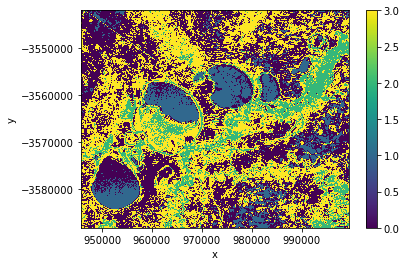

In [36]:
#plot the k-means predictions for a time slice (helps to figure out exactly which class was assigned for 'water')
rg.plot_gmm_classes(np.log(clean.isel(time=35)),kmm)

In [56]:
#looks like class 0 is water, YMMV, the initial condition for the fit is stochastic and changes each time
#predict on all the radar data
kmm_ds = rg.gmm_dataset(np.log(clean),kmm)

In [57]:
gc.collect()

42

In [58]:
#produce an 'is water' dataset and compute a 'WOfS summary' version of this
openw_ds = (kmm_ds == 1)

SARsummary = openw_ds.sum(dim='time',keep_attrs=True)/len(openw_ds)

SARsummary = SARsummary.sortby('y',ascending=False)

In [59]:
# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting
query

{'lat': (-32.53, -32.15),
 'long': (142.16, 142.7),
 'time': ('2017-01-01', '2018-01-01')}

In [43]:
dcO = datacube.Datacube()

xarray dataset has no spatial data; defaulting to plotting without coordinates. This can often be resolved by adding `keep_attrs = True` during an aggregation step
xarray dataset has no spatial data; defaulting to plotting without coordinates. This can often be resolved by adding `keep_attrs = True` during an aggregation step


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f13a21cc9e8>)

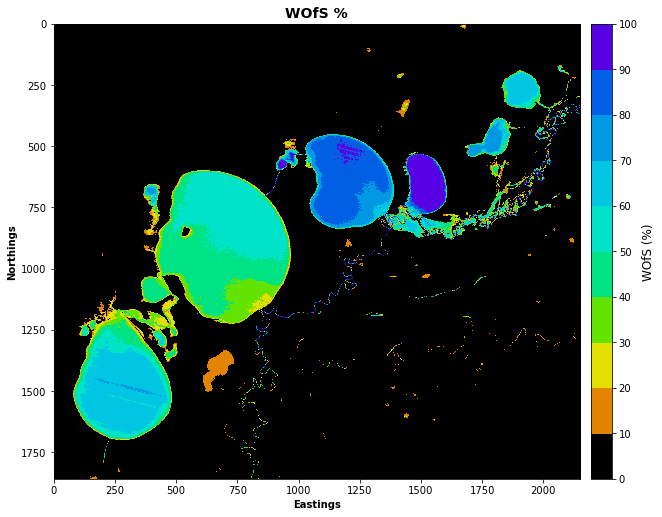

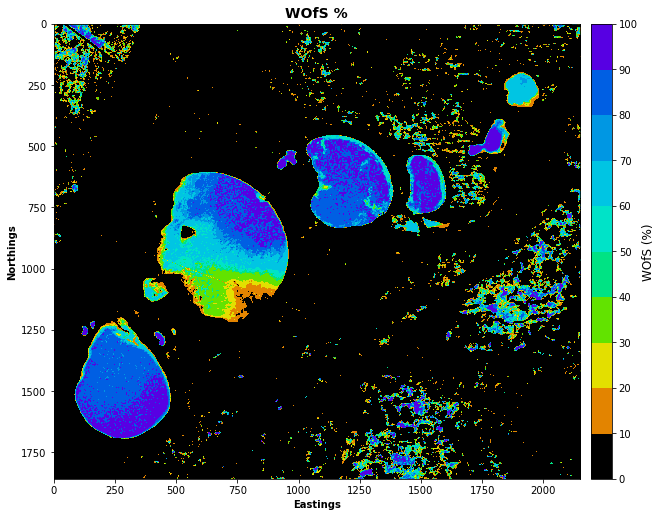

In [60]:
from digitalearthau.utils import wofs_fuser

qtime = ('2018-01-01', '2019-01-01')

query = {
    'lat' : (-32.53,-32.15),
    'long' : (142.16,142.70),
    'time' : qtime
}

wofs_filtered_summary = dcO.load(product = 'wofs_filtered_summary',fuse_func=wofs_fuser, **query)

DEAPlotting.plot_WOfS(wofs_filtered_summary.wofs_filtered_summary.isel(time=0)*100)

DEAPlotting.plot_WOfS(SARsummary*100)

In [52]:
SARsummary

<xarray.DataArray (y: 1859, x: 2149)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 9.458e+05 9.458e+05 9.459e+05 ... 9.995e+05 9.995e+05
  * y        (y) float64 -3.542e+06 -3.542e+06 ... -3.588e+06 -3.588e+06

In [6]:
t,ts = rg.plot_gmm_timeseries(np.log(clean),kmm)

UnboundLocalError: local variable 'times' referenced before assignment

In [497]:
wofls_ts = dcO.load(product = 'wofs_albers', **query)

In [498]:
from datacube.storage import masking
wofls_wet_mask = masking.make_mask(wofls_ts,wet=True)
wofls_dry_mask = masking.make_mask(wofls_ts,dry=True)
wofls_valid_mask = wofls_wet_mask | wofls_dry_mask
#at least 70% cloud-free
wofls_vfrac = wofls_valid_mask.mean(dim=['x','y'])
valid_times = wofls_vfrac.where(wofls_vfrac > 0.7).dropna(dim='time')['time']



wofls_wpercent_ts = wofls_wet_mask.sel(time=valid_times).mean(dim=['x','y'])/wofls_valid_mask.sel(time=valid_times).mean(dim=['x','y'])

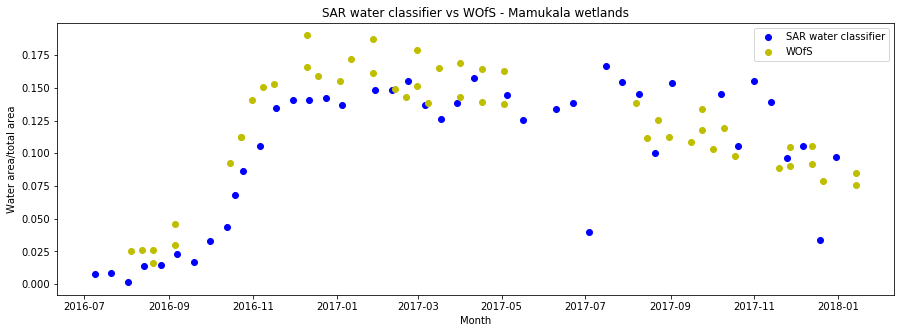

In [63]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(t,ts[:,3],'bo',label='SAR water classifier')
plt.plot(wofls_wpercent_ts['time'],wofls_wpercent_ts['water'],'yo',label='WOfS')
plt.xlabel('Month')
plt.ylabel('Water area/total area')
plt.title('SAR water classifier vs WOfS - Mamukala wetlands')
plt.legend()
plt.show()

In [210]:
sliced_wofls=(wofls_ts.sel(time=valid_times).sel(time=slice('2017-09-01','2017-11-01')))

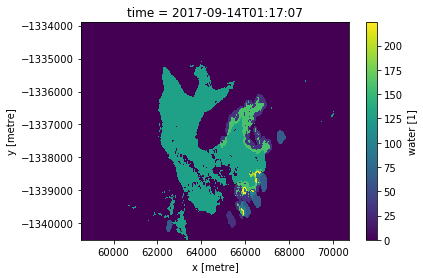

In [211]:
sliced_wofls.isel(time=0).water.plot()

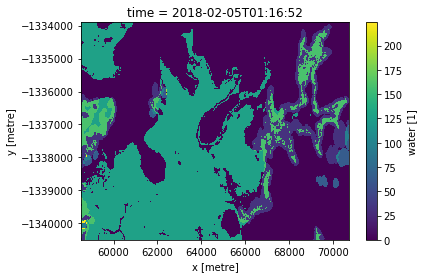

In [213]:
sliced_wofls=(wofls_ts.sel(time=valid_times).sel(time=slice('2018-01-15','2018-02-15')))
sliced_wofls.isel(time=0).water.plot()

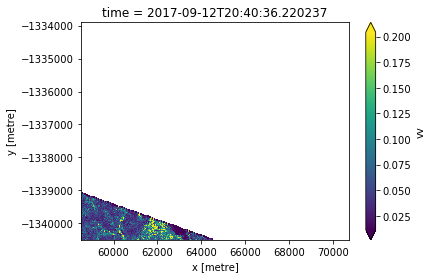

In [257]:
clean.sel(time=slice('2017-09-10','2017-09-15')).vv.plot(robust=True)

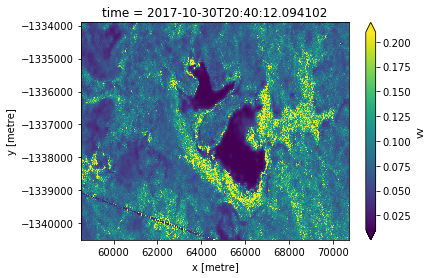

In [230]:
clean.sel(time=slice('2017-10-30','2017-11-03')).vv.plot(robust=True)

In [54]:
#load up Menindee Lakes
qtime = ('2017-01-01', '2018-01-01')

query = {
    'lat' : (-32.53,-32.15),
    'long' : (142.16,142.70),
    'time' : qtime
}

#load the raw SAR scenes
sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

#Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
sardata=sardata.where(sardata!=0)
clean=rf.denoise(sardata)
#mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
#                                           out_shape=sardata.geobox.shape,
#                                           transform=sardata.geobox.affine,
#                                           all_touched=False,
#                                           invert=False)
#clean=clean.where(~mask)

#drop scenes with a lot of NaN pixels
nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

clean = clean.sel(time = valtimes)

In [58]:
#multiprocessing routine to speed up the timeseries calculation
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

index_stops = np.linspace(0,len(clean.time),num=mp.cpu_count()+1,dtype=int)

results = [pool.apply_async(rg.calc_gmm_timeseries,args=(np.log(clean),kmm),kwds={'tmin':index_stops[i],'tmax':index_stops[i+1]}) for i in range(len(index_stops) - 1)]

pool.close()
pool.join()

res_a = [r.get() for r in results]

t = xr.concat([res[0] for res in res_a],dim='time')
ts = np.concatenate(tuple(res[1] for res in res_a))

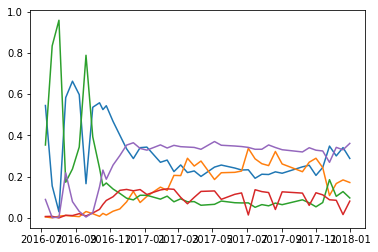

In [39]:
plt.plot(t,ts)

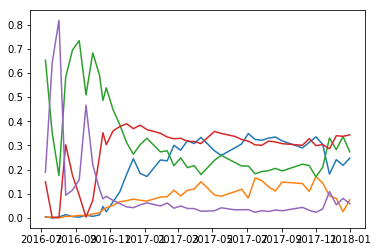

In [544]:
t,ts = rg.plot_gmm_timeseries(np.log(clean),kmm)

In [44]:
wofls_ts = dcO.load(product = 'wofs_albers', **query)

In [46]:
from datacube.storage import masking
wofls_wet_mask = masking.make_mask(wofls_ts,wet=True)
wofls_dry_mask = masking.make_mask(wofls_ts,dry=True)
wofls_valid_mask = wofls_wet_mask | wofls_dry_mask
#at least 70% cloud-free
wofls_vfrac = wofls_valid_mask.mean(dim=['x','y'])
valid_times = wofls_vfrac.where(wofls_vfrac > 0.7).dropna(dim='time')['time']



wofls_wpercent_ts = wofls_wet_mask.sel(time=valid_times).mean(dim=['x','y'])/wofls_valid_mask.sel(time=valid_times).mean(dim=['x','y'])

In [47]:
del(wofls_wet_mask,wofls_dry_mask,wofls_valid_mask)

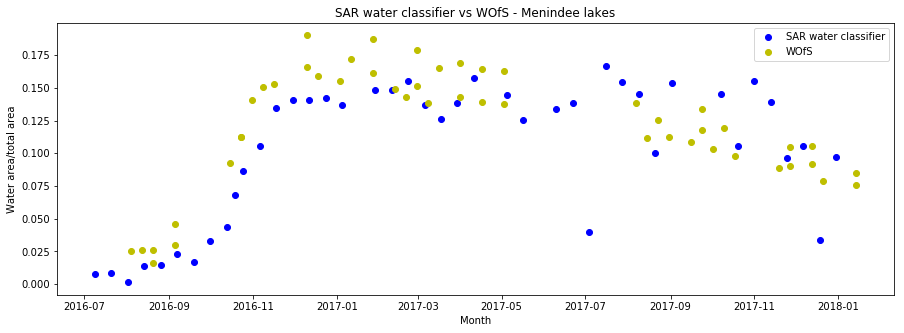

In [64]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(t,ts[:,3],'bo',label='SAR water classifier')
plt.plot(wofls_wpercent_ts['time'],wofls_wpercent_ts['water'],'yo',label='WOfS')
plt.xlabel('Month')
plt.ylabel('Water area/total area')
plt.title('SAR water classifier vs WOfS - Menindee lakes')
plt.legend()
plt.show()

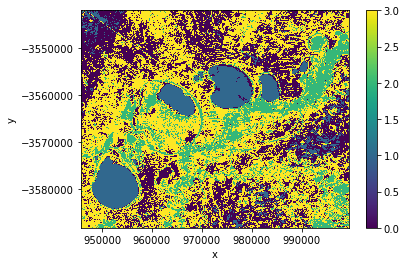

In [62]:
rg.plot_gmm_classes(np.log(clean.isel(time=-1)),kmm)

In [454]:
#Lake Pamamaroo

qtime = ('2017-01-01', '2019-01-01')

query = {
    'lat' : (-32.32,-32.22),
    'long' : (142.40,142.51),
    'time' : qtime
}


In [15]:
def load_cleaned_SAR(query):

    #load the raw SAR scenes
    sardata = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', output_crs='EPSG:3577',resolution=(25,25), **query)

    #Denoise and mask the radar data with the actual polygon - it will have been returned as a rectangle
    sardata=sardata.where(sardata!=0)
    clean=rf.denoise(sardata)
    #mask = rasterio.features.geometry_mask([geom.to_crs(sardata.geobox.crs)for geoms in [geom]],
    #                                           out_shape=sardata.geobox.shape,
    #                                           transform=sardata.geobox.affine,
    #                                           all_touched=False,
    #                                           invert=False)
    #clean=clean.where(~mask)

    #drop scenes with a lot of NaN pixels
    nanmask = ((np.isnan(clean).mean(dim = ['x','y'])) > 0.2).vv
    valtimes = nanmask.where(~nanmask).dropna(dim='time')['time']

    clean = clean.sel(time = valtimes)
    
    return clean

In [20]:
#dodgy monthly composites

from datacube.storage import masking

def wofls_composite(wofls_ts):
    wofls_wet_mask = masking.make_mask(wofls_ts,wet=True)
    wofls_dry_mask = masking.make_mask(wofls_ts,dry=True)
    wofls_valid_mask = (wofls_wet_mask | wofls_dry_mask).any(dim='time')
    
    compo = wofls_wet_mask.any(dim='time').where(wofls_valid_mask)
    return compo.water

def SAR_composite(SAR_ds):
    return SAR_ds.mean(dim='time')
    

In [7]:
import gc

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops

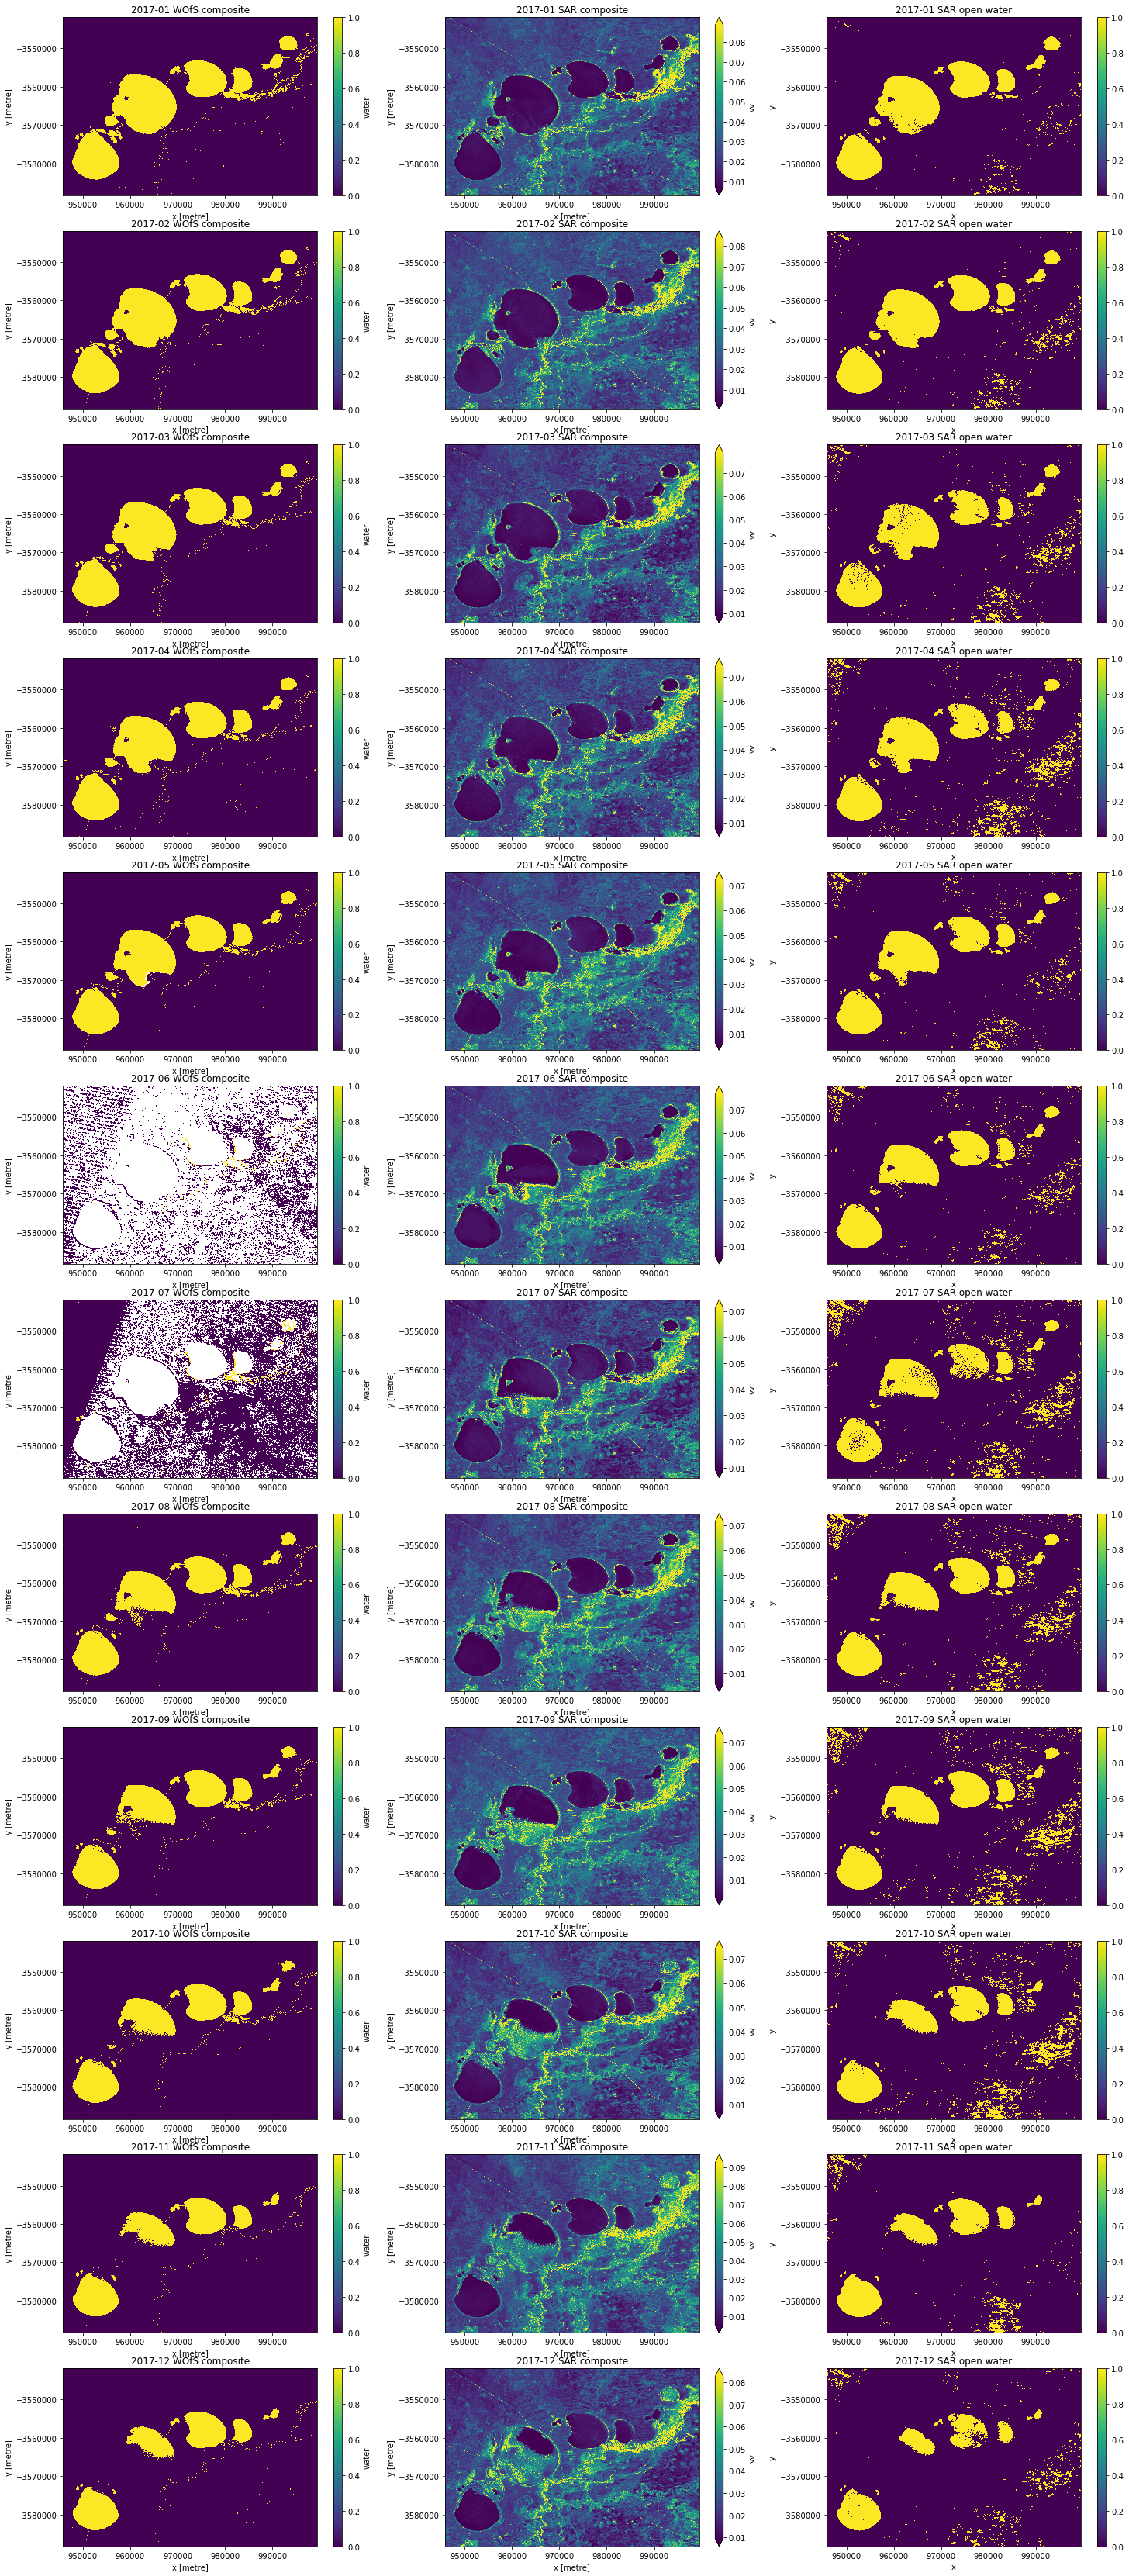

In [35]:
lat = (-32.53,-32.15)
long = (142.16,142.70)


fig,ax = plt.subplots(12,3,figsize=(25,60))

for month in range(1,13):
    first = '2017-'+'{:02d}'.format(month)+'-01'
    last = str(2017+month//12)+'-'+'{:02d}'.format(month%12+1)+'-01'

    query = {
        'lat': lat,
        'long': long,
        'time': (first,last)
    }
    
    
    wofls_ds = dcO.load(product = 'wofs_albers', **query)
    
    if len(wofls_ds.water)>0:
        comp = wofls_composite(wofls_ds)
        if comp is not None:
            comp.plot(ax=ax[month-1,0])
            ax[month-1,0].title.set_text(first[:-3]+' WOfS composite')    
    #calls to gc and del help with avoiding OOM errors
    del(wofls_ds)
    
    sar_ds = load_cleaned_SAR(query)
    
    compSAR = SAR_composite(sar_ds)
    
    del(sar_ds)
    
    compSAR.vv.plot(ax=ax[month-1,1],robust=True)
    ax[month-1,1].title.set_text(first[:-3]+' SAR composite')
    
    plt.sca(ax[month-1,2])
    
    kmm_ds = rg.calc_gmm_classes(np.log(compSAR),kmm)
    (kmm_ds == 1).plot()
    ax[month-1,2].title.set_text(first[:-3]+' SAR open water')
            
    
    gc.collect()


In [46]:
from datacube.storage import masking
wofls_wet_mask = masking.make_mask(wofls_ts,wet=True)
wofls_dry_mask = masking.make_mask(wofls_ts,dry=True)
wofls_valid_mask = wofls_wet_mask | wofls_dry_mask
#at least 70% cloud-free
wofls_vfrac = wofls_valid_mask.mean(dim=['x','y'])
valid_times = wofls_vfrac.where(wofls_vfrac > 0.7).dropna(dim='time')['time']



wofls_wpercent_ts = wofls_wet_mask.sel(time=valid_times).mean(dim=['x','y'])/wofls_valid_mask.sel(time=valid_times).mean(dim=['x','y'])

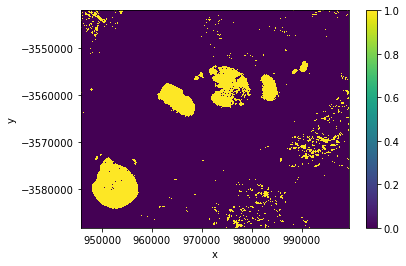

In [33]:
(kmm_ds==1).plot()

In [93]:
#do the monthly timeseries thing
from collections import OrderedDict

lat = (-32.53,-32.15)
long = (142.16,142.70)

wofs_mean_ts = np.array([])
sar_mean_ts = np.array([])


for month in range(1,13):
    first = '2017-'+'{:02d}'.format(month)+'-01'
    last = str(2017+month//12)+'-'+'{:02d}'.format(month%12+1)+'-01'

    query = {
        'lat': lat,
        'long': long,
        'time': (first,last)
    }
    
    
    
    wofls_ds = dcO.load(product = 'wofs_albers', **query)
    
    if len(wofls_ds.water)>0:
        compmean = wofls_composite(wofls_ds).mean(dim=['x','y']).expand_dims('time')
        compmean['time'] = [np.datetime64(first)]
        if wofs_mean_ts.any():
            wofs_mean_ts = xr.concat([wofs_mean_ts,compmean],dim='time')
        else:
            wofs_mean_ts = compmean
            
        
        
        
    #calls to gc and del help with avoiding OOM errors
    del(wofls_ds)
    
    sar_ds = load_cleaned_SAR(query)
    
    compSAR = SAR_composite(sar_ds)
    
    del(sar_ds)
    
    
    kmm_ds = rg.calc_gmm_classes(np.log(compSAR),kmm)
    sarmean = (kmm_ds == 1).mean(dim=['x','y']).expand_dims('time')
    sarmean['time'] = [np.datetime64(first)]
    print(sarmean.time)
    if sar_mean_ts.any():
        sar_mean_ts = xr.concat([sar_mean_ts,sarmean],dim='time')
    else:
        sar_mean_ts = sarmean
    
    
    
    del(compSAR)
            
    
    gc.collect()


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'time' (time: 1)>
array(['2017-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'time' (time: 1)>
array(['2017-02-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-02-01


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'time' (time: 1)>
array(['2017-03-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-03-01


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'time' (time: 1)>
array(['2017-04-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-04-01


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'time' (time: 1)>
array(['2017-05-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-05-01


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'time' (time: 1)>
array(['2017-06-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-06-01


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'time' (time: 1)>
array(['2017-07-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-07-01
<xarray.DataArray 'time' (time: 1)>
array(['2017-08-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-08-01


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'time' (time: 1)>
array(['2017-09-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-09-01
<xarray.DataArray 'time' (time: 1)>
array(['2017-10-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-10-01
<xarray.DataArray 'time' (time: 1)>
array(['2017-11-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-11-01
<xarray.DataArray 'time' (time: 1)>
array(['2017-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01


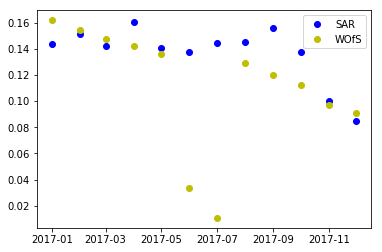

In [100]:
plt.plot(sar_mean_ts['time'],sar_mean_ts,'bo',label='SAR')
plt.plot(wofs_mean_ts['time'],wofs_mean_ts,'yo',label='WOfS')
plt.legend()